In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers as tfl, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
data = []
labels =[]
import glob
galaxy_path = glob.glob('../input/dummy-astronomy-data/Cutout Files/galaxy/*')
star_path = glob.glob('../input/dummy-astronomy-data/Cutout Files/star/*')
for x in galaxy_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(1)                                                

In [3]:
data, labels= np.array(data), np.array(labels)

In [4]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, test_size=0.5,
                                                random_state=42, shuffle=True)

In [6]:
y_train, y_valid = to_categorical(y_train),  to_categorical(y_valid)

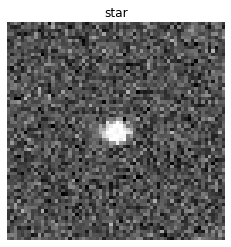

In [7]:
def show_img(x, y, index):
    plt.imshow(x[index])
    if y[index]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    plt.axis('off')    
    plt.show()    

show_img(x_test, y_test, 10)

In [8]:
def identity_block(input_img, filters):
    x_img= input_img
    
    #layer 1
    conv11 = tfl.Conv2D(filters, kernel_size=3, padding='same')(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)
    
    #layer 2
    conv21 = tfl.Conv2D(filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)
    
    # adding layers
    x_add = tfl.Add()([x_img, batch21])
    x_identity = tfl.Activation('relu')(x_add)
    
    return x_identity

In [9]:
def conv_block(input_img, filters):
    x_img = input_img
    
    #layer 1
    conv11 = tfl.Conv2D( filters, kernel_size=3, padding='same', strides=2)(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)
    
    #layer 2
    conv21 = tfl.Conv2D( filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)
    
    #conv block layer
    conv_blk = tfl.Conv2D( filters, kernel_size= 1, strides=2)(x_img)
    
    # adding layers
    x_add = tfl.Add()([batch21, conv_blk])
    x_conv = tfl.Activation('relu')(x_add)
    
    return x_conv

In [10]:
def resnet_model(classes, shape=(256,256,3)):
    
    x= tfl.Input(shape)
    x_rescaled = tfl.Rescaling(scale=1./255)(x)
    #base layer
    c1= tfl.Conv2D(64, kernel_size=7, strides=2, padding='same')(x_rescaled)
    b1= tfl.BatchNormalization()(c1)
    a1= tfl.Activation('relu')(b1)
    pool1= tfl.MaxPool2D(strides=(2,2), pool_size=3)(a1)
    
    # 1st identity block
    iden_layer1 = identity_block(pool1, 64)
    iden_layer2 = identity_block(iden_layer1, 64)
    iden_layer3 = identity_block(iden_layer2, 64)
    
    # 1st convolutional block
    conv_layer1 = conv_block(iden_layer3, 128)
    
    # 2nd identity block
    iden_layer1 = identity_block(conv_layer1, 128)
    iden_layer2 = identity_block(iden_layer1, 128)
    iden_layer3 = identity_block(iden_layer2, 128)
    
    # 2nd convolutional block
    conv_layer1 = conv_block(iden_layer3, 256)
    
    # 3rd identity block
    iden_layer1 = identity_block(conv_layer1, 256)
    iden_layer2 = identity_block(iden_layer1, 256)
    iden_layer3 = identity_block(iden_layer2, 256)
    iden_layer4 = identity_block(iden_layer3, 256)
    iden_layer5 = identity_block(iden_layer4, 256)
    
     # 4rd identity block
    iden_layer1 = identity_block(conv_layer1, 256)
    iden_layer2 = identity_block(iden_layer1, 256)
    iden_layer3 = identity_block(iden_layer2, 256)
    iden_layer4 = identity_block(iden_layer3, 256)
    iden_layer5 = identity_block(iden_layer4, 256)
    
    # 3rd convolutional block
    conv_layer1 = conv_block(iden_layer5, 512)
    
    # 4th identity block
    iden_layer1 = identity_block(conv_layer1, 512)
    iden_layer2 = identity_block(iden_layer1, 512)
    
    # final layer
    
    avg_pool = tfl.AveragePooling2D((2,2), padding='same' )(iden_layer2)
    flat = tfl.Flatten()(avg_pool)
    d1 = tfl.Dense(1024, activation = 'relu')(flat)
    d2 = tfl.Dense(classes, activation='softmax')(d1) 
    model = tf.keras.models.Model(inputs= x, outputs= d2, name='RESNET34_ARCH')
    
    return model

In [11]:
model = resnet_model(2,(64,64,3))

2022-12-12 16:27:08.590553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:27:08.591443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:27:08.600031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:27:08.600875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:27:08.601615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
model.summary()

Model: "RESNET34_ARCH"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________

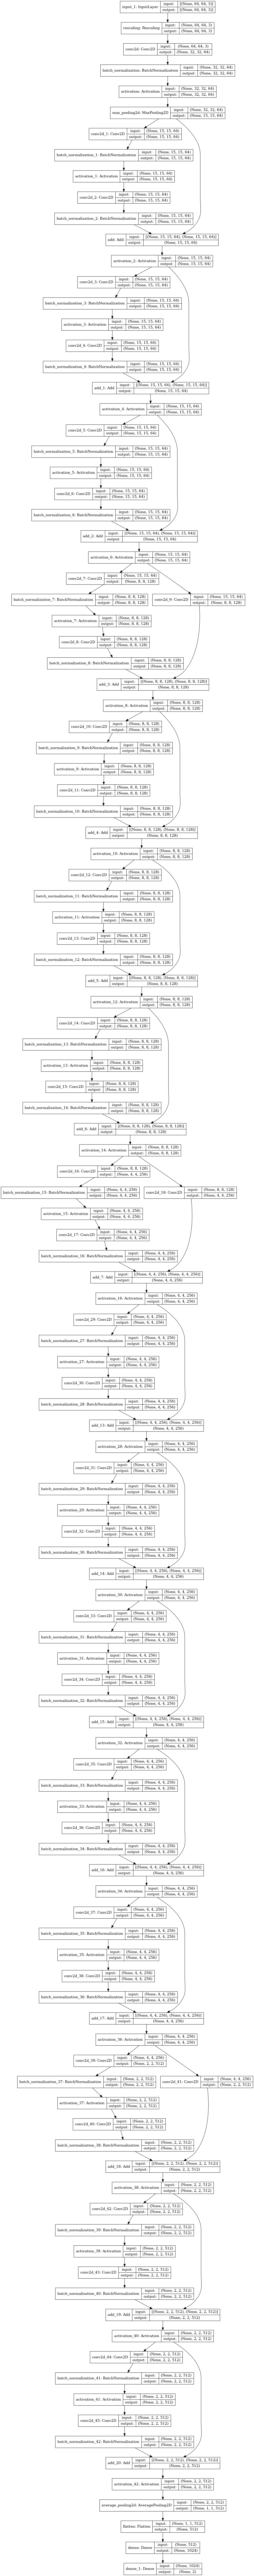

In [13]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [14]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [15]:
model.compile(optimizer= optimizers.Adam(learning_rate=0.01),
             loss='categorical_crossentropy',
                    metrics=METRICS)

In [16]:
import os
paths = {'model_path' : os.path.join('models'), 
         'weights_path' : os.path.join('models','weights'),
         'saved_model_path' : os.path.join('models', 'saved_model'),
         'checkpoint_path' : os.path.join('models','checkpoints')
        }

In [17]:
for key, value in paths.items():
    if not os.path.exists(value):
        !mkdir {value}

In [18]:
# simple early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        paths['checkpoint_path'], monitor='val_auc', verbose=0, save_best_only=True,
                         mode='max', save_freq='epoch')

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

es = EarlyStopping(monitor='val_prc', mode='auto', verbose=1,
                  restore_best_weights=True)

In [19]:
history_resnet = model.fit(x_train, y_train,
                           validation_data=(x_valid, y_valid),
                    epochs=50,
                    verbose=1,
                    batch_size=128,
                          callbacks=[model_ckpt,reduce_lr])

2022-12-12 16:27:12.935203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-12 16:27:17.802706: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 13s 214ms/step - loss: 6.9563 - tp: 2311.0000 - fp: 877.0000 - tn: 2311.0000 - fn: 877.0000 - accuracy: 0.7249 - precision: 0.7249 - recall: 0.7249 - auc: 0.7410 - prc: 0.7107 - val_loss: 297115910144.0000 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7544 - val_prc: 0.7160


2022-12-12 16:27:31.358072: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
25/25 [==============================] - 2s 87ms/step - loss: 0.7310 - tp: 2366.0000 - fp: 822.0000 - tn: 2366.0000 - fn: 822.0000 - accuracy: 0.7422 - precision: 0.7422 - recall: 0.7422 - auc: 0.7889 - prc: 0.7726 - val_loss: 5573.6533 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7544 - val_prc: 0.7160
Epoch 3/50
25/25 [==============================] - 2s 84ms/step - loss: 0.5356 - tp: 2422.0000 - fp: 766.0000 - tn: 2422.0000 - fn: 766.0000 - accuracy: 0.7597 - precision: 0.7597 - recall: 0.7597 - auc: 0.8223 - prc: 0.8135 - val_loss: 61.1943 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7544 - val_prc: 0.7160
Epoch 4/50
25/25 [==============================] - 2s 82ms/step - loss: 0.4453 - tp: 2442.0000 - fp: 746.0000 - tn: 2442.0000 - fn: 746.0000 - accura

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
25/25 [==============================] - 2s 84ms/step - loss: 0.3736 - tp: 2581.0000 - fp: 607.0000 - tn: 2581.0000 - fn: 607.0000 - accuracy: 0.8096 - precision: 0.8096 - recall: 0.8096 - auc: 0.9108 - prc: 0.9128 - val_loss: 11.8346 - val_tp: 305.0000 - val_fp: 94.0000 - val_tn: 305.0000 - val_fn: 94.0000 - val_accuracy: 0.7644 - val_precision: 0.7644 - val_recall: 0.7644 - val_auc: 0.7898 - val_prc: 0.7538


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
25/25 [==============================] - 2s 86ms/step - loss: 0.3510 - tp: 2711.0000 - fp: 477.0000 - tn: 2711.0000 - fn: 477.0000 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9275 - prc: 0.9274 - val_loss: 1.3625 - val_tp: 299.0000 - val_fp: 100.0000 - val_tn: 299.0000 - val_fn: 100.0000 - val_accuracy: 0.7494 - val_precision: 0.7494 - val_recall: 0.7494 - val_auc: 0.8123 - val_prc: 0.7814


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
25/25 [==============================] - 2s 84ms/step - loss: 0.2891 - tp: 2798.0000 - fp: 390.0000 - tn: 2798.0000 - fn: 390.0000 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9494 - prc: 0.9497 - val_loss: 0.4461 - val_tp: 331.0000 - val_fp: 68.0000 - val_tn: 331.0000 - val_fn: 68.0000 - val_accuracy: 0.8296 - val_precision: 0.8296 - val_recall: 0.8296 - val_auc: 0.9015 - val_prc: 0.8941


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
25/25 [==============================] - 2s 83ms/step - loss: 0.2748 - tp: 2827.0000 - fp: 361.0000 - tn: 2827.0000 - fn: 361.0000 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9543 - prc: 0.9537 - val_loss: 0.4050 - val_tp: 328.0000 - val_fp: 71.0000 - val_tn: 328.0000 - val_fn: 71.0000 - val_accuracy: 0.8221 - val_precision: 0.8221 - val_recall: 0.8221 - val_auc: 0.8948 - val_prc: 0.8978
Epoch 9/50
25/25 [==============================] - 2s 82ms/step - loss: 0.2666 - tp: 2828.0000 - fp: 360.0000 - tn: 2828.0000 - fn: 360.0000 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9569 - prc: 0.9573 - val_loss: 0.3803 - val_tp: 342.0000 - val_fp: 57.0000 - val_tn: 342.0000 - val_fn: 57.0000 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571 - val_auc: 0.9167 - val_prc: 0.9144


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/50
25/25 [==============================] - 2s 84ms/step - loss: 0.2493 - tp: 2864.0000 - fp: 324.0000 - tn: 2864.0000 - fn: 324.0000 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9621 - prc: 0.9625 - val_loss: 0.3644 - val_tp: 339.0000 - val_fp: 60.0000 - val_tn: 339.0000 - val_fn: 60.0000 - val_accuracy: 0.8496 - val_precision: 0.8496 - val_recall: 0.8496 - val_auc: 0.9203 - val_prc: 0.9212


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
25/25 [==============================] - 2s 86ms/step - loss: 0.2447 - tp: 2849.0000 - fp: 339.0000 - tn: 2849.0000 - fn: 339.0000 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9638 - prc: 0.9643 - val_loss: 0.5793 - val_tp: 265.0000 - val_fp: 134.0000 - val_tn: 265.0000 - val_fn: 134.0000 - val_accuracy: 0.6642 - val_precision: 0.6642 - val_recall: 0.6642 - val_auc: 0.7700 - val_prc: 0.7822
Epoch 12/50
25/25 [==============================] - 2s 81ms/step - loss: 0.2362 - tp: 2880.0000 - fp: 308.0000 - tn: 2880.0000 - fn: 308.0000 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9663 - prc: 0.9662 - val_loss: 0.6621 - val_tp: 237.0000 - val_fp: 162.0000 - val_tn: 237.0000 - val_fn: 162.0000 - val_accuracy: 0.5940 - val_precision: 0.5940 - val_recall: 0.5940 - val_auc: 0.7024 - val_prc: 0.7224
Epoch 13/50
25/25 [==============================] - 2s 83ms/step - loss: 0.2364 - tp: 2877.0000 - fp: 311.0000 - tn: 2877.0000 - fn: 311.0000 - acc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/50
25/25 [==============================] - 2s 85ms/step - loss: 0.2200 - tp: 2902.0000 - fp: 286.0000 - tn: 2902.0000 - fn: 286.0000 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9703 - prc: 0.9699 - val_loss: 0.2735 - val_tp: 352.0000 - val_fp: 47.0000 - val_tn: 352.0000 - val_fn: 47.0000 - val_accuracy: 0.8822 - val_precision: 0.8822 - val_recall: 0.8822 - val_auc: 0.9559 - val_prc: 0.9531


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/50
25/25 [==============================] - 2s 86ms/step - loss: 0.2110 - tp: 2909.0000 - fp: 279.0000 - tn: 2909.0000 - fn: 279.0000 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9731 - prc: 0.9737 - val_loss: 0.2721 - val_tp: 357.0000 - val_fp: 42.0000 - val_tn: 357.0000 - val_fn: 42.0000 - val_accuracy: 0.8947 - val_precision: 0.8947 - val_recall: 0.8947 - val_auc: 0.9569 - val_prc: 0.9545


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/50
25/25 [==============================] - 2s 85ms/step - loss: 0.2102 - tp: 2910.0000 - fp: 278.0000 - tn: 2910.0000 - fn: 278.0000 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9729 - prc: 0.9726 - val_loss: 0.6812 - val_tp: 267.0000 - val_fp: 132.0000 - val_tn: 267.0000 - val_fn: 132.0000 - val_accuracy: 0.6692 - val_precision: 0.6692 - val_recall: 0.6692 - val_auc: 0.7509 - val_prc: 0.7561
Epoch 22/50
25/25 [==============================] - 2s 82ms/step - loss: 0.2097 - tp: 2924.0000 - fp: 264.0000 - tn: 2924.0000 - fn: 264.0000 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9731 - prc: 0.9731 - val_loss: 0.8116 - val_tp: 254.0000 - val_fp: 145.0000 - val_tn: 254.0000 - val_fn: 145.0000 - val_accuracy: 0.6366 - val_precision: 0.6366 - val_recall: 0.6366 - val_auc: 0.6811 - val_prc: 0.6717
Epoch 23/50
25/25 [==============================] - 2s 82ms/step - loss: 0.2003 - tp: 2932.0000 - fp: 256.0000 - tn: 2932.0000 - fn: 256.0000 - acc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/50
25/25 [==============================] - 2s 84ms/step - loss: 0.1954 - tp: 2927.0000 - fp: 261.0000 - tn: 2927.0000 - fn: 261.0000 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9765 - prc: 0.9763 - val_loss: 0.4210 - val_tp: 313.0000 - val_fp: 86.0000 - val_tn: 313.0000 - val_fn: 86.0000 - val_accuracy: 0.7845 - val_precision: 0.7845 - val_recall: 0.7845 - val_auc: 0.8952 - val_prc: 0.8961
Epoch 26/50
25/25 [==============================] - 2s 85ms/step - loss: 0.1965 - tp: 2936.0000 - fp: 252.0000 - tn: 2936.0000 - fn: 252.0000 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9761 - prc: 0.9757 - val_loss: 0.9143 - val_tp: 218.0000 - val_fp: 181.0000 - val_tn: 218.0000 - val_fn: 181.0000 - val_accuracy: 0.5464 - val_precision: 0.5464 - val_recall: 0.5464 - val_auc: 0.6445 - val_prc: 0.6688
Epoch 27/50
25/25 [==============================] - 2s 83ms/step - loss: 0.1898 - tp: 2944.0000 - fp: 244.0000 - tn: 2944.0000 - fn: 244.0000 - accur

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/50
25/25 [==============================] - 2s 85ms/step - loss: 0.1843 - tp: 2945.0000 - fp: 243.0000 - tn: 2945.0000 - fn: 243.0000 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9787 - prc: 0.9778 - val_loss: 1.8558 - val_tp: 130.0000 - val_fp: 269.0000 - val_tn: 130.0000 - val_fn: 269.0000 - val_accuracy: 0.3258 - val_precision: 0.3258 - val_recall: 0.3258 - val_auc: 0.3622 - val_prc: 0.4215
Epoch 29/50
25/25 [==============================] - 2s 83ms/step - loss: 0.1892 - tp: 2944.0000 - fp: 244.0000 - tn: 2944.0000 - fn: 244.0000 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9777 - prc: 0.9769 - val_loss: 0.4244 - val_tp: 324.0000 - val_fp: 75.0000 - val_tn: 324.0000 - val_fn: 75.0000 - val_accuracy: 0.8120 - val_precision: 0.8120 - val_recall: 0.8120 - val_auc: 0.9065 - val_prc: 0.9052
Epoch 30/50
25/25 [==============================] - 2s 83ms/step - loss: 0.1821 - tp: 2965.0000 - fp: 223.0000 - tn: 2965.0000 - fn: 223.0000 - accur

In [20]:
training_score= history_resnet.history

Text(0.5, 1.0, 'Loss Function')

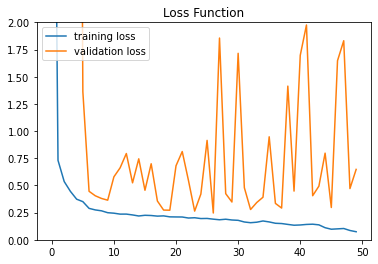

In [21]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'AUC Function')

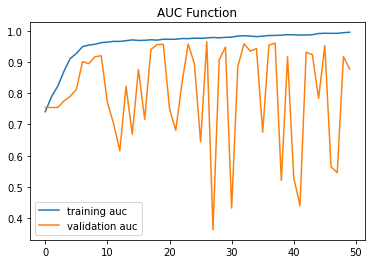

In [22]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')

Text(0.5, 1.0, 'Precision Function')

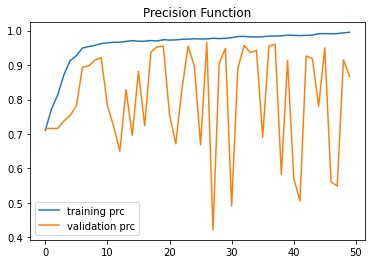

In [23]:
plt.plot(training_score['prc'], label='training prc')
plt.plot(training_score['val_prc'], label='validation prc')
plt.legend()
plt.title('Precision Function')

Text(0.5, 1.0, 'Accuracy Function')

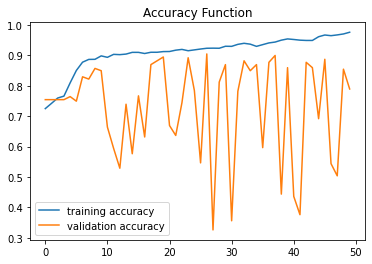

In [24]:
plt.plot(training_score['accuracy'], label='training accuracy')
plt.plot(training_score['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy Function')

In [25]:
model_name= 'resent_star_galaxy.h5'
model.save(paths['saved_model_path'] + model_name)

In [26]:
from sklearn.metrics import roc_curve, auc

In [27]:
loaded_saved_model= keras.models.load_model(paths['saved_model_path']+model_name)
loaded_saved_ckpt= keras.models.load_model(paths['checkpoint_path'])


In [28]:
def evaluate_results(x,y, classes):
    predicted_prob = loaded_saved_ckpt.predict(x)
    fpr= {}
    tpr ={}
    threshold_ ={}
    auc_ ={}
    for i in range(classes):
        fpr[i], tpr[i], threshold_[i]= roc_curve(y, predicted_prob[:,i], pos_label=i)
        auc_[i] = auc(fpr[i], tpr[i])      
    
    return fpr, tpr, threshold_, auc_    
num_classes= 2
fpr, tpr, threshold_, auc_score= evaluate_results(x_test,y_test, num_classes)

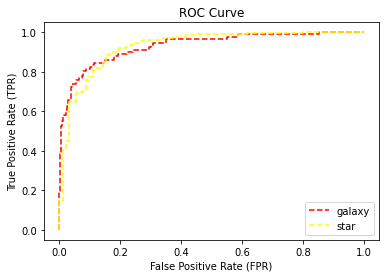

********** 
 AUC score for class GALAXY:  0.9313543599257885 
 ********** 
 AUC score for class STAR:  0.9313543599257884 
 **********


In [29]:
plt.plot(fpr[0],tpr[0], linestyle='--',color='red', label='galaxy')
plt.plot(fpr[1],tpr[1], linestyle='--',color='yellow', label='star')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()
print('*'*10,'\n','AUC score for class GALAXY: ', auc_score[0], '\n', '*'*10,'\n', 'AUC score for class STAR: ', auc_score[1], '\n', '*'*10)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [31]:
# accuracy_score(y_pred,y_test)
# print(classification_report(y_pred,y_test))

NameError: name 'y_pred' is not defined